# 10wk-2: 추천시스템 (1) – optimizer 사용 고급, MF-based 추천시스템

최규빈  
2024-05-08

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/10wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-xl7f2bcPTKMVCe3kHM380M&si=5SO7pni3fXX4kK-4>

# 2. Imports

In [899]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

# 3. 예비학습: optimizer 사용 고급

`-` 주어진 자료가 아래와 같다고 하자.

In [900]:
torch.manual_seed(43052)
x,_ = torch.randn(100).sort()
x = x.reshape(-1,1)
ones= torch.ones(100).reshape(-1,1)
X = torch.concat([ones,x],axis=-1)
ϵ = torch.randn(100).reshape(-1,1)*0.5
y = 2.5+ 4*x + ϵ

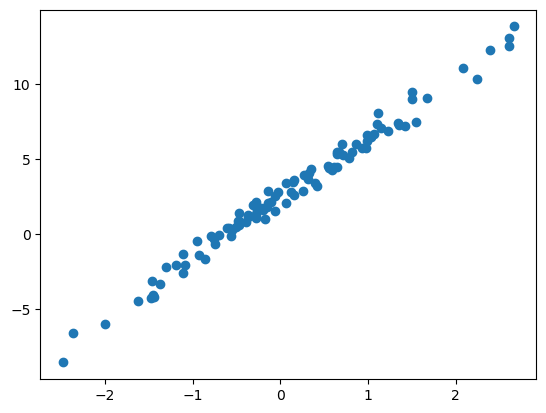

In [901]:
plt.plot(x,y,'o')

`-` 문제1: 아래와 같이 최초의 직선을 생성하였다.

In [902]:
What = torch.tensor([[-5.0],[10.0]],requires_grad=True)

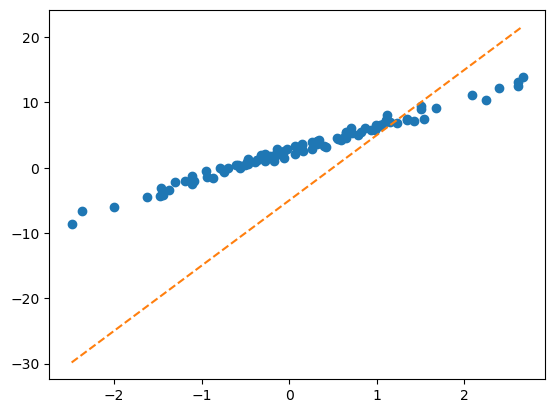

In [905]:
plt.plot(x,y,'o')
plt.plot(x,X@What.data,'--')

`torch.optim.SGD`를 이용하여 What을 update하라. 학습률은 0.1로 설정하고
30회 update하라.

In [906]:
# net  
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD([What],lr=0.1)
#--#
for epoc in range(30):
    # step1 
    yhat = X@What 
    # step2
    loss = loss_fn(yhat,y)
    # step3 
    loss.backward()
    # step4 
    optimizr.step()
    optimizr.zero_grad()

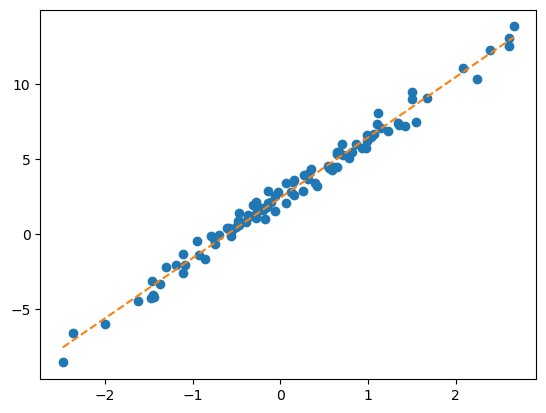

In [907]:
plt.plot(x,y,'o')
plt.plot(x,X@What.data,'--')

`-` 문제2: 아래와 같이 최초의 직선을 생성하였다.

In [919]:
w = torch.tensor(10.0,requires_grad=True)
b = torch.tensor(-5.0,requires_grad=True)

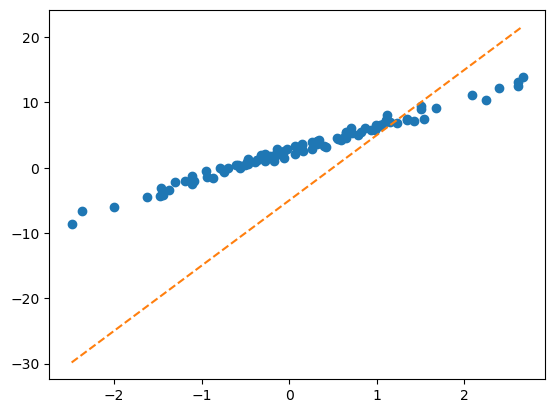

In [920]:
plt.plot(x,y,'o')
plt.plot(x,(x*w + b).data,'--')

`torch.optim.SGD`를 이용하여 What을 update하라. 학습률은 0.1로 설정하고
30회 update하라.

In [922]:
# net  
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD([w,b],lr=0.1)
#--#
for epoc in range(30):
    # step1 
    yhat = x*w+b 
    # step2
    loss = loss_fn(yhat,y)
    # step3 
    loss.backward()
    # step4 
    optimizr.step()
    optimizr.zero_grad()

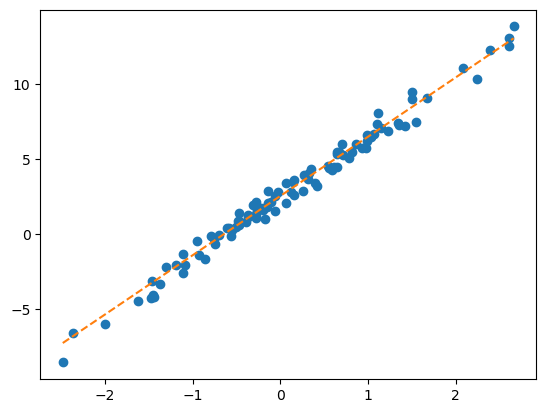

In [923]:
plt.plot(x,y,'o')
plt.plot(x,(x*w + b).data,'--')

# 4. MF-based 추천시스템

ref: <https://namu.wiki/w/나는%20SOLO>

## A. Data: 나는 SOLO

`-` Data

In [458]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view

`-` 데이터를 이해할 때 필요한 가정들 – 제가 마음대로 설정했어요..

-   궁합이 잘맞으면 5점, 잘 안맞으면 0점 이다.
-   MBTI 성향에 따라서 궁함의 정도가 다르다. 특히 I/E의 성향일치가
    중요하다.
-   하니는 모든 사람들과 대체로 궁합이 잘 맞는다.
-   하니는 I성향의 사람들과 좀 더 잘 맞는다.

## B. Fit / Predict

`-` 목표: NaN을 추정

`-` 수동추론: 그럴듯한 숫자를 추정해보자.

-   옥순(IN),영식(IN)의 궁합은? $\to$ 둘다 IN 이므로 잘 맞을듯 $\to$ 4.0
    정도?
-   영자(IN),다호(ES)의 궁합은? $\to$ 잘 안맞을듯
-   하니(I),영호(IS)의 궁합은? $\to$ 하니는 모두 좋아하므로 기본적으로
    4.5 정도 + 하니는 I성향이므로 더 잘 맞을듯 $\to$ 거의 4.9 아닐까?

`-` 좀 더 체계적인 추론 전략: (1) 사람들이 가지고 있는 성향 (2)
사람자체의 절대매력을 수치화 하자.

-   옥순(IN)의 IN성향, 옥순(IN)의 매력 = (1.22, 0.49), 1.21
-   영식(IN)의 IN성향, 영식(IN)의 매력 = (1.20, 0.50), 1.20
-   영자(IN)의 IN성향, 영자(IN)의 매력 = (1.17 ,0.44), 1.25
-   다호(ES)의 IN성향, 다호(ES)의 매력 = (-1.22 ,-0.60), 1.15
-   하니(I)의 IN성향, 하니(I)의 매력 = (0.20,0.00), 3.60
-   영호(IS)의 IS성향, 영호(IS)의 매력 = (1.23 , -0.7), 1.11

**(1)** 옥순(IN)과 영식(IN)의 궁합 $\approx$
옥순의I성향$\times$영식의I성향 $+$ 옥순의N성향$\times$영식의N성향 $+$
옥순의매력 $+$ 영식의매력

In [1107]:
옥순성향 = torch.tensor([1.22,0.49]).reshape(1,2)
옥순매력 = torch.tensor(1.21)
영식성향 = torch.tensor([1.20,0.5]).reshape(1,2)
영식매력 = torch.tensor(1.2)
((옥순성향*영식성향).sum() + 옥순매력 + 영식매력) # 옥순과 영식의 궁합: a ∘ b 로 내적구함 + 이후에 매력을 더함 
(옥순성향 @ 영식성향.T + 옥순매력 + 영식매력) # 옥순과 영식의 궁합: a.T @ b 로 내적구함 + 이후에 매력을 더함

**(2)** 영자(IN)와 다호(ES)의 궁합 $\approx$ 영자I성향$\times$다호I성향
$+$ 영자N성향$\times$다호의N성향 $+$ 영자의매력 $+$ 다호의매력

In [1109]:
영자성향 = torch.tensor([1.17,0.44]).reshape(1,2)
영자매력 = torch.tensor(1.25).reshape(1,1)
다호성향 = torch.tensor([-1.22,-0.6]).reshape(1,2)
다호매력 = torch.tensor(1.15).reshape(1,1)
((영자성향*다호성향).sum() + 영자성향 + 다호성향)
(영자성향 @ 다호성향.T + 영자매력 + 다호매력)

**(3)** 하니(I)와 영호(IS)의 궁합 $\approx$ 하니I성향$\times$영호I성향
$+$ 하니N성향$\times$영호의N성향 $+$ 하니의매력 $+$ 영호의매력

In [1110]:
하니성향 = torch.tensor([0.2,0]).reshape(1,2)
하니매력 = torch.tensor(3.6)
영호성향 = torch.tensor([1.23,-0.7]).reshape(1,2)
영호매력 = torch.tensor(1.11)
((하니성향*영호성향).sum() + 하니매력 + 영호매력)
(하니성향 @ 영호성향.T + 하니매력 + 영호매력)

> 전체적으로 그럴싸함

`-` 전체 사용자의 설정값

In [1111]:
옥순성향 = torch.tensor([1.22,0.49]).reshape(1,2)
영자성향 = torch.tensor([1.17,0.44]).reshape(1,2)
정숙성향 = torch.tensor([1.21,-0.45]).reshape(1,2)
영숙성향 = torch.tensor([1.20,-0.50]).reshape(1,2)
순자성향 = torch.tensor([-1.20,0.51]).reshape(1,2)
현숙성향 = torch.tensor([-1.23,0.48]).reshape(1,2)
서연성향 = torch.tensor([-1.20,-0.48]).reshape(1,2)
보람성향 = torch.tensor([-1.19,-0.49]).reshape(1,2)
하니성향 = torch.tensor([0.2,0]).reshape(1,2)
W = torch.concat([옥순성향,영자성향,정숙성향,영숙성향,순자성향,현숙성향,서연성향,보람성향,하니성향])
b1 = torch.tensor([1.21,1.25,1.10,1.11,1.12,1.13,1.14,1.12,3.6]).reshape(-1,1) 
W,b1

In [1112]:
영식성향 = torch.tensor([1.20,0.5]).reshape(1,2)
영철성향 = torch.tensor([1.22,0.45]).reshape(1,2)
영호성향 = torch.tensor([1.23,-0.7]).reshape(1,2)
광수성향 = torch.tensor([1.21,-0.6]).reshape(1,2)
상철성향 = torch.tensor([-1.28,0.6]).reshape(1,2)
영수성향 = torch.tensor([-1.24,0.5]).reshape(1,2)
규빈성향 = torch.tensor([-1.20,-0.5]).reshape(1,2)
다호성향 = torch.tensor([-1.22,-0.6]).reshape(1,2)
M = torch.concat([영식성향,영철성향,영호성향,광수성향,상철성향,영수성향,규빈성향,다호성향]) # 각 column은 남성출연자의 성향을 의미함
b2 = torch.tensor([1.2,1.10,1.11,1.25,1.18,1.11,1.15,1.15]).reshape(-1,1)
M,b2

`-` 아래의 행렬곱 관찰

In [1113]:
W @ M.T + (b1 + b2.T)

—저거 따져보자—

${\bf W} = \begin{bmatrix} 1.2200 & 0.4900 \\ 1.1700 & 0.4400 \\ 1.2100 & -0.4500 \\ 1.2000 & -0.5000 \\ -1.2000 & 0.5100 \\ -1.2300 & 0.4800 \\ -1.2000 & -0.4800 \\ -1.1900 & -0.4900 \\ 0.2000 & 0.0000 \end{bmatrix}$

${\bf M}^\top = \begin{bmatrix} 1.2000 & 1.2200 & 1.2300 & 1.2100 & -1.2800 & -1.2400 & -1.2000 & -1.2200 \\ 0.5000 & 0.4500 & -0.7000 & -0.6000 & 0.6000 & 0.5000 & -0.5000 & -0.6000 \end{bmatrix}$

${\bf W} @ {\bf M}^\top = \begin{bmatrix} 1.7090 & 1.7089 & 1.1576 & 1.1822 & -1.2676 & -1.2678 & -1.7090 & -1.7824 \\ 1.6240 & 1.6254 & 1.1311 & 1.1517 & -1.2336 & -1.2308 & -1.6240 & -1.6914 \\ 1.2270 & 1.2737 & 1.8033 & 1.7341 & -1.8188 & -1.7254 & -1.2270 & -1.2062 \\ 1.1900 & 1.2390 & 1.8260 & 1.7520 & -1.8360 & -1.7380 & -1.1900 & -1.1640 \\ -1.1850 & -1.2345 & -1.8330 & -1.7580 & 1.8420 & 1.7430 & 1.1850 & 1.1580 \\ -1.2360 & -1.2846 & -1.8489 & -1.7763 & 1.8624 & 1.7652 & 1.2360 & 1.2126 \\ -1.6800 & -1.6800 & -1.1400 & -1.1640 & 1.2480 & 1.2480 & 1.6800 & 1.7520 \\ -1.6730 & -1.6723 & -1.1207 & -1.1459 & 1.2292 & 1.2306 & 1.6730 & 1.7458 \\ 0.2400 & 0.2440 & 0.2460 & 0.2420 & -0.2560 & -0.2480 & -0.2400 & -0.2440 \end{bmatrix}$

$\begin{align*} bias =~& \begin{bmatrix} 1.2100 \\ 1.2500 \\ 1.1000 \\ 1.1100 \\ 1.1200 \\ 1.1300 \\ 1.1400 \\ 1.1200 \\ 3.6000 \end{bmatrix} +\begin{bmatrix} 1.2000 & 1.1000 & 1.1100 & 1.2500 & 1.1800 & 1.1100 & 1.1500 & 1.1500 \end{bmatrix}\\ \\ =~& \begin{bmatrix} 2.4100 & 2.3100 & 2.3200 & 2.4600 & 2.3900 & 2.3200 & 2.3600 & 2.3600 \\ 2.4500 & 2.3500 & 2.3600 & 2.5000 & 2.4300 & 2.3600 & 2.4000 & 2.4000 \\ 2.3000 & 2.2000 & 2.2100 & 2.3500 & 2.2800 & 2.2100 & 2.2500 & 2.2500 \\ 2.3100 & 2.2100 & 2.2200 & 2.3600 & 2.2900 & 2.2200 & 2.2600 & 2.2600 \\ 2.3200 & 2.2200 & 2.2300 & 2.3700 & 2.3000 & 2.2300 & 2.2700 & 2.2700 \\ 2.3300 & 2.2300 & 2.2400 & 2.3800 & 2.3100 & 2.2400 & 2.2800 & 2.2800 \\ 2.3400 & 2.2400 & 2.2500 & 2.3900 & 2.3200 & 2.2500 & 2.2900 & 2.2900 \\ 2.3200 & 2.2200 & 2.2300 & 2.3700 & 2.3000 & 2.2300 & 2.2700 & 2.2700 \\ 4.8000 & 4.7000 & 4.7100 & 4.8500 & 4.7800 & 4.7100 & 4.7500 & 4.7500 \end{bmatrix} \end{align*}$

${\bf W} @ {\bf M}^\top + bias = \begin{bmatrix} 4.1190 & 4.0189 & 3.4776 & 3.6422 & 1.1224 & 1.0522 & 0.6510 & 0.5776 \\ 4.0740 & 3.9754 & 3.4911 & 3.6517 & 1.1964 & 1.1292 & 0.7760 & 0.7086 \\ 3.5270 & 3.4737 & 4.0133 & 4.0841 & 0.4612 & 0.4846 & 1.0230 & 1.0438 \\ 3.5000 & 3.4490 & 4.0460 & 4.1120 & 0.4540 & 0.4820 & 1.0700 & 1.0960 \\ 1.1350 & 0.9855 & 0.3970 & 0.6120 & 4.1420 & 3.9730 & 3.4550 & 3.4280 \\ 1.0940 & 0.9454 & 0.3911 & 0.6037 & 4.1724 & 4.0052 & 3.5160 & 3.4926 \\ 0.6600 & 0.5600 & 1.1100 & 1.2260 & 3.5680 & 3.4980 & 3.9700 & 4.0420 \\ 0.6470 & 0.5477 & 1.1093 & 1.2241 & 3.5292 & 3.4606 & 3.9430 & 4.0158 \\ 5.0400 & 4.9440 & 4.9560 & 5.0920 & 4.5240 & 4.4620 & 4.5100 & 4.5060 \end{bmatrix}$

`-` ${\bf W} @ {\bf M}^\top + bias$ 의 (1,1)의 원소값을 계산해보면
아래와 같다.

-   옥순의I성향$\times$영식의I성향 $+$ 옥순의N성향$\times$영식의N성향
    $+$ 옥순의매력 $+$ 영식의매력 = 4.1190
-   $1.220 \times 1.2000 + 0.4900 \times 0.5000 + 1.2100 + 2.4100 = 4.1190$

`-` 궁합매트릭스: ${\bf W} @ {\bf M}^\top + bias$를 계산하면 (9,8) 인
행렬이 나올텐데 이 행렬의 $(i,j)$의 원소는 $i$-th 여성출연자와 $j$-th
남성출연자가 얼마나 잘 맞는지를 나타내는 숫자가 된다. (숫자가 높을수록
잘 맞음) 편의상 이 수업에서는 이 매트릭스를 “궁합매트릭스” 라고
정의하자.

`-` 주어진 자료와 우리가 임의로 만든 궁합매트릭스를 비교해보자.

In [893]:
print(f"주어진자료:\n{np.array(df_view)}")
print(f"궁합매트릭스:\n{np.array(W @ M.T + b1 + b2.T).round(2)}")

주어진자료:
[[ nan 4.02 3.45 3.42 0.84 1.12 0.43 0.49]
 [3.93 3.99 3.63 3.43 0.98 0.96 0.52  nan]
 [3.52 3.42 4.05 4.06 0.39  nan 0.93 0.99]
 [3.43 3.57  nan 3.95 0.56 0.52 0.89 0.89]
 [1.12  nan 0.59 0.43 4.01 4.16 3.52 3.38]
 [0.94 1.05 0.32 0.45 4.02 3.78  nan 3.54]
 [0.51 0.56 0.88 0.89 3.5  3.64 4.04 4.1 ]
 [0.48 0.51 1.03  nan 3.52 4.   3.82  nan]
 [4.85 4.82  nan 4.98 4.53 4.39 4.45 4.52]]
궁합매트릭스:
[[4.12 4.02 3.48 3.64 1.12 1.05 0.65 0.58]
 [4.07 3.98 3.49 3.65 1.2  1.13 0.78 0.71]
 [3.53 3.47 4.01 4.08 0.46 0.48 1.02 1.04]
 [3.5  3.45 4.05 4.11 0.45 0.48 1.07 1.1 ]
 [1.14 0.99 0.4  0.61 4.14 3.97 3.46 3.43]
 [1.09 0.95 0.39 0.6  4.17 4.01 3.52 3.49]
 [0.66 0.56 1.11 1.23 3.57 3.5  3.97 4.04]
 [0.65 0.55 1.11 1.22 3.53 3.46 3.94 4.02]
 [5.04 4.94 4.96 5.09 4.52 4.46 4.51 4.51]]

`-` 우리의 전략

1.  ${\bf W} @ {\bf M}^\top + bias$의 값과 `df_view` 의 값이 **`nan`을
    제외한 곳에서** 거의 비슷하게 되도록 ${\bf W}$, ${\bf M}$, $bias$를
    잘 때려맞추면 되는것 아니야?

2.  1을 만족하는 ${\bf W}$, ${\bf M}$, $bias$를 찾았으면 그 숫자들을
    이용하여 `df_view`의 `nan` 을 추정한다.

`-` 따라서 모형은 아래와 같이 볼 수 있다.

$${\tt df\_view} \approx {\bf W}@{\bf M}^\top + bias$$

`-` 아래의 정보를 참고하여 위의 수식을 다시 정리하면..

|    W     |    M     |  여성특징  |  남성특징  |   I궁합   |   N궁합    |  bias   |  yhat  |  y   |
|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|
| 옥순(IN) | 영철(IN) | 1.22, 0.49 | 1.22, 0.45 | 1.4884[1] | 0.2205[2]  | 2.31[3] | 4.0189 | 4.02 |
| 옥순(IN) | 영호(IS) | 1.22, 0.49 | 1.23, -0.7 | 1.1576[4] | -0.3423[5] | 2.32[6] | 3.4776 | 3.45 |
|    …     |    …     |     …      |     …      |     …     |     …      |         |        |      |
| 하니(I)  | 영식(IN) | 0.20, 0.00 | 1.20, 0.5  |   0.24    |     0      |   4.8   |  5.04  | 4.85 |
|    …     |    …     |     …      |     …      |     …     |     …      |         |        |      |

-   걱정1: 5.0이 넘는 값도 있네? 잘못잡으면 음수가 나올지도?
-   걱정2: 저러한 yhat (4.0189, 3.4776, 5.04)을 만드는게 꼭 저 조합만
    있는게 아님. 당장에 남성의 바이어스에 일괄적으로 -2를 넣고 여성의
    바이어스에 일괄적으로 +2를 해도 성립함.

`-` (걱정은 뒤로 하고) `yhat` $\approx$ `y` 를 만족하도록 해보자! (1)
아무 `yhat` 을 구한다. (2) `yhat`과 `y`가 비슷한 정도를 측정한다. (3) 더
적당한 `yhat`값을 update한다.

-   `yhat`은 어떻게 구하지? (여성특징$\otimes$남성특징).sum() + bias?
-   그럼 여성특징,남성특징,여성bias(=여성매력),남성bias(=남성매력)는
    어떻게 구하지?? 생각해보니까 데이터에서 주어진건 아니잖아??

`-` `여성특징`,`남성특징`, `여성bais`,`남성bais` 를 어떻게 만들지?

-   그전엔 어떻게 했지?? `W`을 보고 적당히 특징을 상상하고
    `여성특징`,`여성bias`의 값을 때려넣음 + `M`를 보고 적당히 특징을
    상상하고 `남성특징`, `남성bias`의 값을 채워 넣음.
-   자동화하려면? `W` $\to$ `여성특징`, `W` $\to$ `여성bias`, `M` $\to$
    `남성특징`, `M` $\to$ `남성bias` 인 함수를 만들자.

`-` 앞으로 할일1: 아래와 같은 함수들을 만들자.

-   옥순 $\to$ 옥순의 특징 = (1.22, 0.49)
-   옥순 $\to$ 옥순의 매력 = 1.22
-   영철 $\to$ 영철의 특징 = (1.22, 0.45)
-   영철 $\to$ 영철의 매력 = 1.22 …

`-` 앞으로 할일2: 우리가 익숙한 셋팅 (step1~4)

1.  `여성특징`, `여성bias`, `남성특징`, `남성bias` $\to$ `yhat` 를 수행
2.  `y` $\approx$ `yhat` 인지 체크: `loss = loss_fn(yhat,y)`
3.  `loss.backward()`
4.  더 나은 `여성특징`, `여성bias`, `남성특징`, `남성bias` 로 update!

## C. 할일1의 구현

`-` dataframe의 변형

[1] 1.22 \*1.22 = 1.4884

[2] 0.49 \* 0.45 = 0.2205

[3] 1.21+1.1 = 2.31

[4] 1.22 \*1.23 = 1.5006

[5] 0.49 \* -0.7 = -0.3423

[6] 1.21+1.11 = 2.32

In [46]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
df_train

`-` 이름을 숫자화

In [72]:
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}

In [77]:
df_train['X1']= df_train['W'].map(w)
df_train['X2']= df_train['M'].map(m)
df_train

`-` 텐서화 + one_hot-인코딩

In [93]:
X1 = torch.tensor(df_train['X1'])
X2 = torch.tensor(df_train['X2'])
E1 = torch.nn.functional.one_hot(X1).float()
E2 = torch.nn.functional.one_hot(X2).float()

In [116]:
print(f"y.shape: {y.shape},\t y.dtype: {y.dtype}")
print(f"X1.shape: {X1.shape},\t X1.dtype: {X1.dtype} // X1.unique: {X1.unique()}")
print(f"X2.shape: {X2.shape},\t X2.dtype: {X2.dtype} // X2.unique: {X2.unique()}")
print(f"E1.shape: {E1.shape},\t E1.dtype: {E1.dtype} -- shape에서 9는 여성이 9명이라는 의미")
print(f"E2.shape: {E2.shape},\t E2.dtype: {E2.dtype} -- shape에서 8은 남성이 8명이라는 의미")

y.shape: torch.Size([63, 1]),    y.dtype: torch.float32
X1.shape: torch.Size([63]),  X1.dtype: torch.int64 // X1.unique: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
X2.shape: torch.Size([63]),  X2.dtype: torch.int64 // X2.unique: tensor([0, 1, 2, 3, 4, 5, 6, 7])
E1.shape: torch.Size([63, 9]),   E1.dtype: torch.float32 -- shape에서 9는 여성이 9명이라는 의미
E2.shape: torch.Size([63, 8]),   E2.dtype: torch.float32 -- shape에서 8은 남성이 8명이라는 의미

`-` `X1` -\> `여성특징`, `X1` -\> `여성bias`, `X2` -\> `남성특징`, `X2`
-\> `남성bias` 구현

In [118]:
l1 = torch.nn.Linear(in_features=9, out_features=2, bias=False) # "E1->여성특징"인 함수 
b1 = torch.nn.Linear(in_features=9, out_features=1, bias=False) # "E1->여성bias"인 함수 
l2 = torch.nn.Linear(in_features=8, out_features=2, bias=False) # "E2->남성특징"인 함수 
b2 = torch.nn.Linear(in_features=8, out_features=1, bias=False) # "E2->남성bias"인 함수 

## D. 할일2의 구현 – step1~4 수행

`-` step1: yhat을 구하자.

In [147]:
torch.manual_seed(43052)
l1 = torch.nn.Linear(in_features=9, out_features=2, bias=False) # "E1->여성특징"인 함수 
b1 = torch.nn.Linear(in_features=9, out_features=1, bias=False) # "E1->여성bias"인 함수 
l2 = torch.nn.Linear(in_features=8, out_features=2, bias=False) # "E2->남성특징"인 함수 
b2 = torch.nn.Linear(in_features=8, out_features=1, bias=False) # "E2->남성bias"인 함수 
W_features = l1(E1) # l1(onehot(X1))
W_bias = b1(E1) # b1(onehot(X1))
M_features = l2(E2) # l2(onehot(X2))
M_bias = b2(E2) # b2(onehot(X2))

In [148]:
sig = torch.nn.Sigmoid()
score = (W_features*M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bias
yhat = sig(score)*5

`-` step2: 손실계산

In [149]:
loss_fn = torch.nn.MSELoss()
loss = loss_fn(yhat,y)

`-` step3: 미분

(미분전)

In [150]:
l1.weight.data, b1.weight.data, l2.weight.data, b2.weight.data

In [151]:
l1.weight.grad, b1.weight.grad, l2.weight.grad, b2.weight.grad

(미분)

In [153]:
loss.backward()

(미분후)

In [154]:
l1.weight.data, b1.weight.data, l2.weight.data, b2.weight.data

In [155]:
l1.weight.grad, b1.weight.grad, l2.weight.grad, b2.weight.grad

`-` step4: update

(옵티마이저 선언)

In [164]:
params = list(l1.parameters())+list(l2.parameters())+list(b1.parameters())+list(b2.parameters())
optimizr = torch.optim.Adam(params, lr=0.1) 

(update전)

In [166]:
l1.weight.data, b1.weight.data, l2.weight.data, b2.weight.data

In [167]:
l1.weight.grad, b1.weight.grad, l2.weight.grad, b2.weight.grad

(update)

In [168]:
optimizr.step()

(update후)

In [169]:
l1.weight.data, b1.weight.data, l2.weight.data, b2.weight.data

In [170]:
l1.weight.grad, b1.weight.grad, l2.weight.grad, b2.weight.grad

(zero_grad)

In [171]:
optimizr.zero_grad()

(zero_grad후)

In [172]:
l1.weight.data, b1.weight.data, l2.weight.data, b2.weight.data

In [173]:
l1.weight.grad, b1.weight.grad, l2.weight.grad, b2.weight.grad

## E. 코드정리

In [232]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n vector 
X2 = torch.tensor(df_train['M'].map(m)) # length-n vector 
E1 = torch.nn.functional.one_hot(X1).float()
E2 = torch.nn.functional.one_hot(X2).float()
y = torch.tensor(df_train['y']).float().reshape(-1,1)
#--#
torch.manual_seed(43052)
l1 = torch.nn.Linear(in_features=9, out_features=2, bias=False)
b1 = torch.nn.Linear(in_features=9, out_features=1, bias=False)
l2 = torch.nn.Linear(in_features=8, out_features=2, bias=False)
b2 = torch.nn.Linear(in_features=8, out_features=1, bias=False)
sig = torch.nn.Sigmoid()
loss_fn = torch.nn.MSELoss()
params = list(l1.parameters())+list(b1.parameters())+list(l2.parameters())+list(b2.parameters())
optimizr = torch.optim.Adam(params, lr=0.1) 
#--#
for epoc in range(100):
    ## step1 
    W_features = l1(E1)
    W_bias = b1(E1)
    M_features = l2(E2) 
    M_bias = b2(E2)
    score = (W_features * M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bias
    yhat = sig(score) * 5 
    ## step2 
    loss = loss_fn(yhat,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

In [233]:
torch.concat([yhat,y],axis=1)[::4] # 꽤 잘맞음

## F. 모형의 해석 – 쉬운경우

In [276]:
df_match = pd.DataFrame((W_features*M_features).data).set_axis(['잠재특징궁합1','잠재특징궁합2'],axis=1)
df_bias = pd.DataFrame(torch.concat([W_bias, M_bias],axis=1).data).set_axis(['여성bias','남성bias'],axis=1)
df_features = pd.concat([df_train.loc[:,'W':'M'],df_match,df_bias],axis=1)
df_features[:56]

In [277]:
df_features[56:]

## G. 모형의 해석 – 어려운 경우

`-` 적합을 시켜보자.

In [278]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n vector 
X2 = torch.tensor(df_train['M'].map(m)) # length-n vector 
E1 = torch.nn.functional.one_hot(X1).float()
E2 = torch.nn.functional.one_hot(X2).float()
y = torch.tensor(df_train['y']).float().reshape(-1,1)
#--#
torch.manual_seed(8)
l1 = torch.nn.Linear(in_features=9, out_features=2, bias=False)
b1 = torch.nn.Linear(in_features=9, out_features=1, bias=False)
l2 = torch.nn.Linear(in_features=8, out_features=2, bias=False)
b2 = torch.nn.Linear(in_features=8, out_features=1, bias=False)
sig = torch.nn.Sigmoid()
loss_fn = torch.nn.MSELoss()
params = list(l1.parameters())+list(b1.parameters())+list(l2.parameters())+list(b2.parameters())
optimizr = torch.optim.Adam(params, lr=0.1) 
#--#
for epoc in range(100):
    ## step1 
    W_features = l1(E1)
    W_bias = b1(E1)
    M_features = l2(E2) 
    M_bias = b2(E2)
    score = (W_features * M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bias
    yhat = sig(score) * 5 
    ## step2 
    loss = loss_fn(yhat,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

`-` 잘 맞추는듯

In [279]:
torch.concat([yhat,y],axis=1)[::4] # 꽤 잘맞음

`-` 해석을 해보자.

In [280]:
df_match = pd.DataFrame((W_features*M_features).data).set_axis(['잠재특징궁합1','잠재특징궁합2'],axis=1)
df_bias = pd.DataFrame(torch.concat([W_bias, M_bias],axis=1).data).set_axis(['여성bias','남성bias'],axis=1)
df_features = pd.concat([df_train.loc[:,'W':'M'],df_match,df_bias],axis=1)
df_features[:56]

In [281]:
df_features[56:]

-   I보다 E성향 남성이 좀 더 인기 있음.
-   E보다 I성향 여성이 좀 더 인기 있음.
-   궁합1: (IN, IN) = 0.3 // (IN, IS) = 0.8 // (IN, EN) = -1.0 // (IN,
    ES) = -0.5
-   궁합2: (IN, IN) = 1.4 // (IN, IS) = 0.4 // (IN, EN) = -0.4 // (IN,
    ES) = -1.4

In [291]:
df_features[df_features.W.str.contains('IN') & df_features.M.str.contains('ES')]

## H. `NaN` 에 대한 예측 – 숙제

# 5. HW

아래의 코드를 활용하여 net를 적합시켜라.

In [1169]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n vector 
X2 = torch.tensor(df_train['M'].map(m)) # length-n vector 
E1 = torch.nn.functional.one_hot(X1).float()
E2 = torch.nn.functional.one_hot(X2).float()
y = torch.tensor(df_train['y']).float().reshape(-1,1)
#--#
torch.manual_seed(43052)
l1 = torch.nn.Linear(in_features=9, out_features=2, bias=False)
b1 = torch.nn.Linear(in_features=9, out_features=1, bias=False)
l2 = torch.nn.Linear(in_features=8, out_features=2, bias=False)
b2 = torch.nn.Linear(in_features=8, out_features=1, bias=False)
sig = torch.nn.Sigmoid()
loss_fn = torch.nn.MSELoss()
params = list(l1.parameters())+list(b1.parameters())+list(l2.parameters())+list(b2.parameters())
optimizr = torch.optim.Adam(params, lr=0.1) 
#--#
for epoc in range(100):
    ## step1 
    W_features = l1(E1)
    W_bias = b1(E1)
    M_features = l2(E2) 
    M_bias = b2(E2)
    score = (W_features * M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bias
    yhat = sig(score) * 5 
    ## step2 
    loss = loss_fn(yhat,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

적합된 네트워크를 바탕으로 아래의 값에 대한 예측을 수행하라.

In [1178]:
df_test = pd.DataFrame({'W':['옥순(IN)','보람(ES)','하니(I)'],'M':['영식(IN)','다호(ES)','영호(IS)']})
df_test

**hint** 답은 아래와 같다.

In [1183]:
yyhat.data